### This notebook plays atari skiing for the Deephack-RL contest.

All the source code is [here](https://github.com/yandexdataschool/tinyverse/tree/deephack-rl)

Unlike many other solutions, we only use one hack and i'm going to explain it shortly.
Otherwises it trains a simple feedforward A3C algorithm with tinyverse.
Below you will find a set of bash scripts that runs the algorithm, so it may be a good idea to first run in and than read the writeup.

#### Reward trick
The original DQN wasn't very good at this game, and here's the reason: the reward function is very hard. 

OpenAI Gym has a very convenient interface for wrapping rewards, so that's what we did:
```
from gym.core import Wrapper
class RewardForPassingGates(Wrapper):
    """Skiing wrapper that rewards player +1 for passing gates only."""
    def _reset(self):
        """On game reset, remember the hash of initial score"""
        s = self.env.reset()
        self.prev_score_hash = hash(s[31:38,67:81].tobytes()) #hash of the image chunk with scoreboard
        return s
    def _step(self,action):
        """on each step, if score has changed, give +1 reward, else +0"""
        s,_,done,info = self.env.step(action)
        new_score_hash = hash(s[31:38,67:81].tobytes()) #hash of the same image chunk
        
        #reward = +1 if we have just crossed the gate, else 0
        r = int(new_score_hash != self.prev_score_hash)
        
        #remember new score
        self.prev_score_hash = new_score_hash
        return s,r,done,info
```

We can then use the environment thusly:
```
env = gym.make("Skiing-v0")
env = RewardForPassingGates(env)
```

Notably, so far as we know, the optimal policy under this reward is to get through all the gates as quickly as possible, which also gives the optimum to the original reward [we believe].


### Why we did that? What else could we do?

The original reward function:
* -1~-10 negative reward on every tick, 
* no immediate reward for passing gates
* some weird ~-10^4 reward at the very end, summarizing the whole performance.

This is bad for two reasons: first, the rewards can be as large as -30k, which will blow up most gradient descent algorithms, should you use deep reinforcement learning.

Second and main reason is that this reward function is as _sparse_ and as _delayed_ as it can be.
The problem is effectively almost from the Monte-Carlo domain (read [here])(http://people.inf.elte.hu/lorincz/Files/RL_2006/SuttonBook.pdf) because you can only evaluate the policy once you've played a full game.

Temporal difference methods (Q-learning, SARSA, actor-critic) are extremely poorly suited for that kind of problem. The objective function for most of them tends to follow this pattern:

$$ Q(s_t,a_t) = r_t + \gamma \cdot r_{t+1} + \gamma^2 \cdot r_{t+2} + ... $$

Where $Q(s_t,a_t)$ is action value and $r_t$ is MDP reward at timestep t.



For $ \gamma = 0.99 $ , the value of _passing the first gate_ essentially becomes


$$ Q(s,a) = 0 + 0.99 \cdot 0 + 0.99^2 \cdot 0 + ... + 0.9 ^ 5000 \cdot reward_at_the_end $$

Assuming the progressed for 5000 ticks which is quite realistic. Note, however that __0.99^5k ~ 10^-22__.

Conversely, _agent does not even assume that his actions influenced the final score_. No wonder DQN can't solve the game.

As a teaser, we're working on a way that would allow agent to infer the action values in this kinds of environments, but it's far from ready yet and it may be [sadly] unscalable to practical environments.

Now when you substitute the rewards with +1 for passing the gates only, the reward now behaves just like the reward for [breakout](https://gym.openai.com/envs/Breakout-v0). Agent receives +1 rewards every 20-50 frames. This kind of problem can be easily solved with any deep RL algorithm. _Our next challenge is to make it work as fast as we can_.

### Algorithm

Inspired by [this](http://rll.berkeley.edu/deeprlcourse/docs/nuts-and-bolts.pdf), we decided to start with something very simple for our problem.

We decided to use [policy gradient methods](https://www.youtube.com/watch?v=KHZVXao4qXs) since they are known to have faster convergence properties. We started with Advantage Actor Critic (also explained in the video).

The main idea of an algorithm is that you learn both policy $\pi(a|s)$ (action probabilities) and state value function $V(s)$. In practice, these are the two outputs of the neural network:
<img src="https://s27.postimg.org/ge52gzx0j/a2c_deep.png" width=800>

The value function __V(s)__ is trained with a standard temporal difference loss (to minimize):
$$ (r(s,a) +\gamma V(s') - V(s))^2 $$

While the policy is optimized with an equivalent of policy gradient (to maximize):
$$ log \pi(a|s) \cdot(r(s,a) +\gamma \cdot V(s') - V(s)) $$

While the last equation was derived through some pure math (logderivative trick followed by variance theorem), you can explain it with a very simple intuition:
* Critic __V(s)__ tries to estimate the state value, as in value iteration.
* Actor __pi(a|s)__ tries to maximize probability of actions that __exceed expectations__ of critic.

$ (r(s,a) +\gamma \cdot V(s') - V(s)) $ can be viewed as (what_you_actually_got - what_you_should_have_got).

Thus, if critic thought V(s) = 1, and actor picked an an action that yielded r = 2 and V(s') = 3, than actor exceeded expectations $r + \gamma \cdot V(s') - V(s) > 0$ and the probability of taking such action should increase.

Instead of epsilon-greedy exploration, we regularized the actor with entropy, making it prefer to leave some randomness into it's actions, effectively exploring the environment. Idea mentioned [here](https://arxiv.org/abs/1602.01783).

This algorithm would fully converge in 18~30 hours on other simple atari games like pong/breakout. To improve convergence, we used [eligibility traces](https://webdocs.cs.ualberta.ca/~sutton/book/ebook/node72.html) (also covered in the policy gradient video).

The difference is essentially that if previously we used a one-step temporal difference
$$ (r(s,a) +\gamma V(s') - V(s))^2 $$

A 3-step eligibility trace would be:
$$ (r(s,a) +\gamma r(s',a') + \gamma^2 r(s'',a'') + \gamma^3 V(s''') - V(s))^2 $$

For stability reasons, we used a 25-step eligibility traces :) [More info](https://arxiv.org/abs/1506.02438) on them for actor-critic.

Since the algorithm is on-policy, we only used a very small experience replay buffer. 
The problem was that if replay buffer is large, than your agent will train on sessions that it recorded whence it was still stupid and an on-policy algorithm will learn that stupid policy. That's ... stupid.

We only stored 5000 last sub-sessions(each is just 25 ticks) which is roughly equivalent to 20 games. Since we recorded sessions with 10 parallel [tinyverse](https://github.com/yandexdataschool/tinyverse) players, this buffer was completely renewed over 20-30 seconds depending on machine.


### Network architecture

Like Pong or Breakout, Skiing with our new reward function can be viewed as a fully-observable MDP (roughly) as long as you know current __position__, __velocity and acceleration__ of all the objects. While we don't actually observe all the variables in the game state (~RAM), we know enough to build an optimal strategy, thus a full observability assumption is harmless.

However, we can't see the object velocity from just one frame (or well, we could derive it from object shapes, but that's hard). We could also use recurrent neural networks as agent memory to let it remember all the past observations, but we decided to go wit ha simpler solution.

Just like the [original DQN](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf), we use a 4-frame buffer that stores last 4 images agent has seen. From these you can easily extract object motion and acceleration.

We resize game images to (64,64), store tham in a frame buffer and feed the resulting (4,64,64) tensors to a simple neural network:

```
conv0 = Conv2DLayer(<4-frame window>,32,5,stride=2,nonlinearity=elu)
conv1 = Conv2DLayer(conv0,32,5,stride=2,nonlinearity=elu)
conv2 = Conv2DLayer(conv1,64,5,stride=1,nonlinearity=elu)
dense = DenseLayer(dropout(conv2,0.1),512,nonlinearity=tanh)

#actor head
policy_layer = DenseLayer(dense,n_actions,nonlinearity=T.nnet.softmax) 

#critic head
V_layer = DenseLayer(dense,1,nonlinearity=None)

```
Some notes on the network architecture
* We use strides instead of max-pooling for computational simplicity, just like the original DQN
* Since we use smaller image size (than dqn), we can afford smaller convolutional layers.
* We used elu instead of relu because it has a betten mean and less of "dying ReLU" problem
* __We forgot to remove dropout from the policy__, probably at our peril. It could be better without it. On the other hand, dropout facilitates exploration... and adds noize to the policy radient :(

We implemented the network and actor-critic with [Lasagne](https://github.com/Lasagne/Lasagne/) + [AgentNet](https://github.com/yandexdataschool/agentnet) and ran experiments with early version of [tinyverse](https://github.com/yandexdataschool/tinyverse) to speed up training.

#### Improvement ideas
- dropout :DDD
- agent still sometimes misses the ultimate gate, giving him -30k reward. It may be a good idea to add more reward for the very last gate AND make sure agent can distinguish red gate from others
- try different framebuffer size or recurrent memory
- change image preprocessing so that it's clearer
- add intrinsic motivation-based exploration
- incorporate the original rewards (whatever they mean) with the new ones
- try [optimality tightening](https://arxiv.org/abs/1611.01606)
- train for 8 more hours >.<

#### boasting
- Total coding time: 2h 11m (with tinyverse and lasagne/agentnet)
- Final model training time: ~8h (with GPU gf1080)




### Run stuff

In [1]:
%%bash --bg
#create several player processes. Each process plays games and saves results
#the loop below spawns 10 players. If you are doing this on a laptop, reducing to 2-4 is okay
for i in `seq 1 10`; 
do
        THEANO_FLAGS=device=cpu,floatX=float32 python tinyverse atari.py play -b 3 --port 6789 &
done  

Starting job # 0 in a separate thread.


In [3]:
%%bash --bg
#create learner process on GPU. batch size 10
THEANO_FLAGS=device=gpu4,floatX=float32 python tinyverse atari.py train -b 10 --port 6789 &

Starting job # 2 in a separate thread.


### View stuff

In [2]:
%%bash
#play 5 games, show results (re-run whenever you want score)
#Tris particular score was recorded 7 hours through training
python tinyverse atari.py eval -n 5 --port 6789

Episode finished after 781 timesteps with reward=20
Episode finished after 731 timesteps with reward=20
Episode finished after 737 timesteps with reward=20
Episode finished after 758 timesteps with reward=20
Episode finished after 811 timesteps with reward=20


[2017-01-18 08:11:03,138] Making new env: Skiing-v0
[2017-01-18 08:11:03,171] Clearing 12 monitor files from previous run (because force=True was provided)
[2017-01-18 08:11:03,188] Starting new video recorder writing to /home/hedgedir/tinyversers/skiverse/records/openaigym.video.0.20910.video000000.mp4
[2017-01-18 08:11:11,969] Starting new video recorder writing to /home/hedgedir/tinyversers/skiverse/records/openaigym.video.0.20910.video000001.mp4
[2017-01-18 08:11:41,854] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/tinyversers/skiverse/records')


### Upload stuff

In [10]:
#same as python tinyverse skiing_original_reward.py eval -n 100

from skiing_original_reward import make_experiment
from tinyverse.database import Database
db = Database(port=6789)
exp = make_experiment(db)

exp.evaluate(100)

[2017-01-18 08:23:38,440] Making new env: Skiing-v0
[2017-01-18 08:23:38,489] Clearing 6 monitor files from previous run (because force=True was provided)
[2017-01-18 08:23:38,516] Starting new video recorder writing to /home/hedgedir/tinyversers/skiverse/records/openaigym.video.0.2488.video000000.mp4
[2017-01-18 08:23:47,232] Starting new video recorder writing to /home/hedgedir/tinyversers/skiverse/records/openaigym.video.0.2488.video000001.mp4


Episode finished after 735 timesteps with reward=-4168.0
Episode finished after 847 timesteps with reward=-4183.0
Episode finished after 729 timesteps with reward=-3646.0
Episode finished after 749 timesteps with reward=-4181.0
Episode finished after 5991 timesteps with reward=-30000.0
Episode finished after 730 timesteps with reward=-3629.0
Episode finished after 781 timesteps with reward=-3854.0


[2017-01-18 08:25:25,809] Starting new video recorder writing to /home/hedgedir/tinyversers/skiverse/records/openaigym.video.0.2488.video000008.mp4


Episode finished after 786 timesteps with reward=-3921.0
Episode finished after 749 timesteps with reward=-3716.0
Episode finished after 848 timesteps with reward=-4237.0
Episode finished after 781 timesteps with reward=-3906.0
Episode finished after 743 timesteps with reward=-3623.0
Episode finished after 771 timesteps with reward=-3834.0
Episode finished after 800 timesteps with reward=-4022.0
Episode finished after 751 timesteps with reward=-3746.0
Episode finished after 774 timesteps with reward=-3867.0
Episode finished after 790 timesteps with reward=-4441.0
Episode finished after 844 timesteps with reward=-4188.0
Episode finished after 794 timesteps with reward=-3979.0
Episode finished after 786 timesteps with reward=-3901.0
Episode finished after 731 timesteps with reward=-3644.0
Episode finished after 738 timesteps with reward=-3641.0
Episode finished after 743 timesteps with reward=-3659.0
Episode finished after 763 timesteps with reward=-3738.0
Episode finished after 737 time

[2017-01-18 08:27:47,617] Starting new video recorder writing to /home/hedgedir/tinyversers/skiverse/records/openaigym.video.0.2488.video000027.mp4


Episode finished after 856 timesteps with reward=-4280.0
Episode finished after 864 timesteps with reward=-4252.0
Episode finished after 6015 timesteps with reward=-30000.0
Episode finished after 737 timesteps with reward=-3734.0
Episode finished after 783 timesteps with reward=-3902.0
Episode finished after 859 timesteps with reward=-4303.0
Episode finished after 739 timesteps with reward=-3674.0
Episode finished after 870 timesteps with reward=-4823.0
Episode finished after 714 timesteps with reward=-3693.0
Episode finished after 753 timesteps with reward=-3779.0
Episode finished after 774 timesteps with reward=-3931.0
Episode finished after 877 timesteps with reward=-4386.0
Episode finished after 797 timesteps with reward=-4022.0
Episode finished after 753 timesteps with reward=-3706.0
Episode finished after 741 timesteps with reward=-4183.0
Episode finished after 803 timesteps with reward=-4040.0
Episode finished after 752 timesteps with reward=-3718.0
Episode finished after 737 ti

[2017-01-18 08:34:16,928] Starting new video recorder writing to /home/hedgedir/tinyversers/skiverse/records/openaigym.video.0.2488.video000064.mp4


Episode finished after 786 timesteps with reward=-3869.0
Episode finished after 792 timesteps with reward=-4014.0
Episode finished after 790 timesteps with reward=-3904.0
Episode finished after 855 timesteps with reward=-4303.0
Episode finished after 726 timesteps with reward=-3618.0
Episode finished after 764 timesteps with reward=-3857.0
Episode finished after 861 timesteps with reward=-4280.0
Episode finished after 743 timesteps with reward=-3726.0
Episode finished after 854 timesteps with reward=-4280.0
Episode finished after 735 timesteps with reward=-3663.0
Episode finished after 745 timesteps with reward=-3684.0
Episode finished after 729 timesteps with reward=-3648.0
Episode finished after 788 timesteps with reward=-3864.0
Episode finished after 770 timesteps with reward=-3829.0
Episode finished after 738 timesteps with reward=-3706.0
Episode finished after 756 timesteps with reward=-3731.0
Episode finished after 803 timesteps with reward=-3927.0
Episode finished after 751 time

[2017-01-18 08:39:30,417] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/tinyversers/skiverse/records')


Episode finished after 745 timesteps with reward=-4149.0


[-4168.0,
 -4183.0,
 -3646.0,
 -4181.0,
 -30000.0,
 -3629.0,
 -3854.0,
 -3921.0,
 -3716.0,
 -4237.0,
 -3906.0,
 -3623.0,
 -3834.0,
 -4022.0,
 -3746.0,
 -3867.0,
 -4441.0,
 -4188.0,
 -3979.0,
 -3901.0,
 -3644.0,
 -3641.0,
 -3659.0,
 -3738.0,
 -3691.0,
 -3766.0,
 -4280.0,
 -4252.0,
 -30000.0,
 -3734.0,
 -3902.0,
 -4303.0,
 -3674.0,
 -4823.0,
 -3693.0,
 -3779.0,
 -3931.0,
 -4386.0,
 -4022.0,
 -3706.0,
 -4183.0,
 -4040.0,
 -3718.0,
 -3686.0,
 -3876.0,
 -3841.0,
 -3846.0,
 -3684.0,
 -3911.0,
 -4037.0,
 -3927.0,
 -14964.0,
 -4278.0,
 -3716.0,
 -30000.0,
 -3874.0,
 -3741.0,
 -3959.0,
 -3889.0,
 -3954.0,
 -3723.0,
 -3936.0,
 -3674.0,
 -3869.0,
 -4014.0,
 -3904.0,
 -4303.0,
 -3618.0,
 -3857.0,
 -4280.0,
 -3726.0,
 -4280.0,
 -3663.0,
 -3684.0,
 -3648.0,
 -3864.0,
 -3829.0,
 -3706.0,
 -3731.0,
 -3927.0,
 -3734.0,
 -30000.0,
 -4297.0,
 -3979.0,
 -3723.0,
 -3801.0,
 -3871.0,
 -3995.0,
 -3914.0,
 -3851.0,
 -4186.0,
 -3713.0,
 -3901.0,
 -3663.0,
 -4215.0,
 -3653.0,
 -3774.0,
 -3889.0,
 -4275.0,
 -414

In [16]:
import gym
gym.upload("./records/","alg_z0IkjjWzTmqXgECJ3e1iA",
           api_key=<your_api_key>)

[2017-01-18 08:49:20,773] [Skiing-v0] Uploading 100 episodes of training data
[2017-01-18 08:49:21,761] [Skiing-v0] Uploading videos of 5 training episodes (673553 bytes)
[2017-01-18 08:49:23,241] [Skiing-v0] Creating evaluation object from ./records/ with learning curve and training video
[2017-01-18 08:49:24,077] 
****************************************************
You successfully uploaded your evaluation on Skiing-v0 to
OpenAI Gym! You can find it at:

    https://gym.openai.com/evaluations/eval_BSWA660qSIaVAsigWXhiBA

****************************************************


# Some auxilary monitoring

* The dashboard we used throughout training. A bit messy. Displays average reward per timestep * 5000.

In [4]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import theano
import theano.tensor as T
import pickle

import atari
from tinyverse.database import Database

db = Database(port=6789)
experiment=atari.make_experiment(db)


n_sessions: 5253


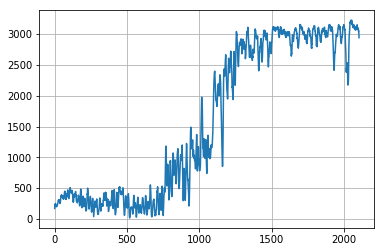

r	V		Ent	Logits
+0.0 +2.636 (+0.336) +0.925 | 0.30(-0.01) 0.12(+0.00) 0.59(+0.00)
+0.0 +2.671 (+0.324) +0.831 | 0.32(-0.01) 0.06(+0.01) 0.62(+0.00)
+0.0 +2.694 (+0.335) +0.978 | 0.46(+0.11) 0.42(-0.09) 0.12(-0.02)
+0.0 +2.773 (+0.234) +0.566 | 0.07(+0.00) 0.09(+0.00) 0.83(-0.01)
+0.0 +2.810 (+0.218) +1.079 | 0.24(-0.06) 0.39(-0.10) 0.36(+0.16)
+0.0 +2.902 (+0.094) +1.051 | 0.31(+0.12) 0.47(-0.09) 0.22(-0.03)
+0.0 +2.976 (+0.005) +1.029 | 0.26(+0.08) 0.23(+0.07) 0.51(-0.15)
+0.0 +2.933 (+0.151) +1.046 | 0.34(-0.04) 0.46(+0.02) 0.20(+0.02)
+0.0 +2.947 (+0.183) +1.068 | 0.35(+0.13) 0.23(-0.04) 0.42(-0.09)
+0.0 +3.029 (+0.081) +0.662 | 0.26(+0.01) 0.72(-0.01) 0.02(+0.00)
+0.0 +3.058 (+0.085) +0.906 | 0.29(-0.00) 0.60(+0.00) 0.11(+0.00)
+1.0 +3.097 (+0.071) +1.065 | 0.31(-0.02) 0.45(+0.04) 0.24(-0.01)
+0.0 +2.136 (+0.035) +1.006 | 0.54(+0.08) 0.24(-0.12) 0.21(+0.04)
+0.0 +2.116 (+0.118) +1.090 | 0.31(-0.03) 0.39(+0.06) 0.30(-0.03)
+0.0 +2.163 (+0.068) +1.003 | 0.21(+0.01) 0.55(-0.00) 0.24(-

KeyboardInterrupt: 

In [12]:
avg_reward_per_session = []

from IPython.display import clear_output
while True:
    if db.redis.exists("weights"):
        weights = db.loads(db.redis.get('weights'))
        if any(map(np.any,map(np.isnan,weights))):
            print("Weights broken!!!")
    
    print("n_sessions:",db.redis.llen("sessions"))
    plt.plot(avg_reward_per_session)
    plt.xlabel("time (arbitrary ticks)")
    plt.ylabel("sum of rewards in 5k subsessions")
    plt.grid()
    plt.show()
    
    
    R=0
    for i in range(5000)[::-1]:
        s,a,r,d,m = db.loads(db.redis.lindex('sessions',i))
        R += sum(r)
    avg_reward_per_session.append(R)
    clear_output(True)
    

In [18]:
!ps aux | grep tinyverse

root      6326 90.6  0.7 79039712 928644 pts/11 Rl+ 06:42   0:44 python tinyverse atari.py train -b 10
root      6475 90.9  0.2 71643972 347380 pts/8 Rl   06:42   0:28 python tinyverse atari.py play -b 1
root      6476 87.8  0.2 71643852 348072 pts/8 Rl   06:42   0:27 python tinyverse atari.py play -b 1
root      6477 89.0  0.2 71643968 349932 pts/8 Rl   06:42   0:27 python tinyverse atari.py play -b 1
root      6478 87.4  0.2 71643552 347084 pts/8 Rl   06:42   0:27 python tinyverse atari.py play -b 1
root      6479 87.4  0.2 71643540 354384 pts/8 Rl   06:42   0:27 python tinyverse atari.py play -b 1
root      6480 84.1  0.2 71643848 347368 pts/8 Rl   06:42   0:26 python tinyverse atari.py play -b 1
root      6481 91.0  0.2 71643512 349676 pts/8 Rl   06:42   0:28 python tinyverse atari.py play -b 1
root      6482 87.4  0.2 71643512 347188 pts/8 Sl   06:42   0:27 python tinyverse atari.py play -b 1
root      6483 86.0  0.2 71643848 348648 pts/8 Rl   06:42   0:26 python tinyverse atari.p

# Dump weights

In [19]:
from tinyverse import Database
from atari import AtariA3C
db = Database(port=6789)
agent = AtariA3C(db).agent
db.load_all_params(agent)

In [27]:
from agentnet.utils.persistence import save,load
save(agent.policy,"weights_8h_training.pcl")

# massacre processes

* Will soon make a cleaner version through ```python tinyverse clear```

In [23]:
!kill -9 $(ps aux | grep tinyverse | awk '{print $2}') #uncomment to hard kill all
from tinyverse.database import Database
db = Database()
for key in db.redis.keys():
    db.redis.delete(key)